# Analyzing and Predicting Tip Behavior of Ride Hailing Passengers in Chicago

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
%matplotlib inline  

import random

import warnings
warnings.filterwarnings("ignore")

## The Data

Ride hailing data pulled from the [City of Chicago Data website](https://data.cityofchicago.org/Transportation/Transportation-Network-Providers-Trips/m6dm-c72p). Included in the data are how long each trip took, the time, date, and approximate location that trips were picked up and dropped off, the amount of tips the driver received for each ride, and whether or not a trip was shared. Added to the data set were a few weather metrics as follows.

Weather was pulled the [National Oceanic and Atmospheric Administration](https://www.ncdc.noaa.gov/cdo-web/search) for the Chicago area. Only three weather metrics were used: Daily Precipitation and Snowfall (both in inches) and Daily Average Temperature in Fahrenheit. For each day, all three measures were averaged over each weather station servicing the Chicago metropolitan.

The data pulled covers the time period between November 1, 2018 to March 31, 2019.

In [47]:
#Use the following cell of code to download new data from the database; otherwise previously queried data can be
#uploaded from a local file in the next cell
'''
#Importing Chicago Ride Hailing Data
from sodapy import Socrata

client = Socrata("data.cityofchicago.org", None)

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("m6dm-c72p", limit=20000)

# Convert to pandas DataFrame
trip_data = pd.DataFrame.from_records(results)

trip_data.to_csv('Chicago_Ride_Hailing_Data.csv')
'''

'\n#Importing Chicago Ride Hailing Data\nfrom sodapy import Socrata\n\nclient = Socrata("data.cityofchicago.org", None)\n\n# First 2000 results, returned as JSON from API / converted to Python list of\n# dictionaries by sodapy.\nresults = client.get("m6dm-c72p", limit=20000)\n\n# Convert to pandas DataFrame\ntrip_data = pd.DataFrame.from_records(results)\n\ntrip_data.to_csv(\'Chicago_Ride_Hailing_Data.csv\')\n'

In [2]:
trips = pd.read_csv('Chicago_Ride_Hailing_Data.csv')

In [3]:
trips.columns

Index(['Unnamed: 0', 'additional_charges', 'dropoff_census_tract',
       'dropoff_centroid_latitude', 'dropoff_centroid_location',
       'dropoff_centroid_longitude', 'dropoff_community_area', 'fare',
       'pickup_census_tract', 'pickup_centroid_latitude',
       'pickup_centroid_location', 'pickup_centroid_longitude',
       'pickup_community_area', 'shared_trip_authorized', 'tip',
       'trip_end_timestamp', 'trip_id', 'trip_miles', 'trip_seconds',
       'trip_start_timestamp', 'trip_total', 'trips_pooled'],
      dtype='object')

In [4]:
trips['trip_start_timestamp'].sort_values().head()

10645    2018-11-01T00:00:00.000
970      2018-11-01T00:15:00.000
19872    2018-11-01T00:15:00.000
13718    2018-11-01T00:45:00.000
6457     2018-11-01T01:45:00.000
Name: trip_start_timestamp, dtype: object

In [5]:
trips['trip_start_timestamp'].sort_values().tail()

3414     2019-03-29T23:30:00.000
3189     2019-03-29T23:45:00.000
12698    2019-03-29T23:45:00.000
19769    2019-03-29T23:45:00.000
7687     2019-03-29T23:45:00.000
Name: trip_start_timestamp, dtype: object

In [6]:
trips.shape

(20000, 22)

In [7]:
#Splitting the trip_start_timestamp and trip_end_timestamp columns into their constituent time components.
ts_year = []
ts_month = []
ts_day = []
ts_hour = []
ts_minute = []
ts_sec = []

for i in range(len(trips['trip_end_timestamp'])):
    
    d, t = trips['trip_end_timestamp'][i].split('T')
    
    year, month, day = d.split('-')
    hour, minute, sec = t.split(':')
    
    ts_year.append(year)
    ts_month.append(month)
    ts_day.append(day)
    ts_hour.append(hour)
    ts_minute.append(minute)
    ts_sec.append(sec)

trips['tsend_year'] = ts_year
trips['tsend_month'] = ts_month
trips['tsend_day'] = ts_day
trips['tsend_hour'] = ts_hour
trips['tsend_minute'] = ts_minute
trips['tsend_sec'] = ts_sec

trips['tsend_year'] = trips['tsend_year'].astype('int64')
trips['tsend_month'] = trips['tsend_month'].astype('int64')
trips['tsend_day'] = trips['tsend_day'].astype('int64')
trips['tsend_hour'] = trips['tsend_hour'].astype('int64')
trips['tsend_minute'] = trips['tsend_minute'].astype('int64')
trips['tsend_sec'] = trips['tsend_sec'].astype('float64')

In [8]:
ts_full_date = []
ts_year = []
ts_month = []
ts_day = []
ts_hour = []
ts_minute = []
ts_sec = []

for i in range(len(trips['trip_start_timestamp'])):
    
    d, t = trips['trip_start_timestamp'][i].split('T')
    
    year, month, day = d.split('-')
    hour, minute, sec = t.split(':')
    
    ts_full_date.append(d)
    ts_year.append(year)
    ts_month.append(month)
    ts_day.append(day)
    ts_hour.append(hour)
    ts_minute.append(minute)
    ts_sec.append(sec)

trips['DATE'] = ts_full_date
trips['tsstart_year'] = ts_year
trips['tsstart_month'] = ts_month
trips['tsstart_day'] = ts_day
trips['tsstart_hour'] = ts_hour
trips['tsstart_minute'] = ts_minute
trips['tsstart_sec'] = ts_sec

trips['tsstart_year'] = trips['tsstart_year'].astype('int64')
trips['tsstart_month'] = trips['tsstart_month'].astype('int64')
trips['tsstart_day'] = trips['tsstart_day'].astype('int64')
trips['tsstart_hour'] = trips['tsstart_hour'].astype('int64')
trips['tsstart_minute'] = trips['tsstart_minute'].astype('int64')
trips['tsstart_sec'] = trips['tsstart_sec'].astype('float64')

In [9]:
#Importing Weather Data
weather = pd.read_csv('../../../__DATA__/Chicago_Weather_Data_2.csv')

In [10]:
#Averaging all data for each day across all weather stations
weather_avg = weather.groupby('DATE').mean().reset_index()
display(weather_avg.head())

#Filling in missing average Tempurature values with the average of the daily max and min temperature.
index = weather_avg['TAVG'].isnull().index
for i in index:
    weather_avg.loc[i,'TAVG'] = (weather_avg['TMAX'][i] + weather_avg['TMIN'][i])/2
weather_avg['TAVG'].isnull().sum()

,DATE,DAPR,MDPR,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TOBS
0,2018-11-01,NaN,NaN,0.004831,0.0,0.0,51.0,54.9,44.9,47.428571
1,2018-11-02,NaN,NaN,0.035086,0.0,0.0,44.0,51.6,36.6,39.428571
2,2018-11-03,6.5,0.485000,0.006636,0.0,0.0,42.0,49.8,33.3,38.714286
3,2018-11-04,NaN,NaN,0.123545,0.0,0.0,48.0,51.4,40.2,47.714286
4,2018-11-05,3.0,0.666667,0.494771,0.0,0.0,48.0,51.2,43.8,46.285714


0

In [11]:
#reducing the weather dataframe down to the necessary columns
cols = ['DATE', 'PRCP',
       'SNOW', 'TAVG']
weather_df = weather_avg[cols]
weather_df.head(5)

,DATE,PRCP,SNOW,TAVG
0,2018-11-01,0.004831,0.0,49.90
1,2018-11-02,0.035086,0.0,44.10
2,2018-11-03,0.006636,0.0,41.55
3,2018-11-04,0.123545,0.0,45.80
4,2018-11-05,0.494771,0.0,47.50


In [12]:
#Merging weather and ride hailing data into data frame trips_df
trips_df = trips.merge(weather_df, on='DATE')

#Dropping unused/unimportant columns
cols_to_drop = ['dropoff_census_tract','dropoff_centroid_latitude','dropoff_centroid_longitude',
               'pickup_census_tract','pickup_centroid_latitude','pickup_centroid_longitude']

trips_df = trips_df.loc[:, ~(trips_df.columns).isin(cols_to_drop)]
'''Note that dropoff/pickup_centroid_locations were withheld in order for invidual rides traveling outside
of Chicago to be dropped.'''

#Dropping rides from the data set that originated or ended outside of Chicago
trips_df = trips_df.dropna(axis=0)

print(trips_df.isnull().sum().sum())
trips_df.shape

0


(17607, 32)

In [13]:
trips_df.columns

Index(['Unnamed: 0', 'additional_charges', 'dropoff_centroid_location',
       'dropoff_community_area', 'fare', 'pickup_centroid_location',
       'pickup_community_area', 'shared_trip_authorized', 'tip',
       'trip_end_timestamp', 'trip_id', 'trip_miles', 'trip_seconds',
       'trip_start_timestamp', 'trip_total', 'trips_pooled', 'tsend_year',
       'tsend_month', 'tsend_day', 'tsend_hour', 'tsend_minute', 'tsend_sec',
       'DATE', 'tsstart_year', 'tsstart_month', 'tsstart_day', 'tsstart_hour',
       'tsstart_minute', 'tsstart_sec', 'PRCP', 'SNOW', 'TAVG'],
      dtype='object')

## Engineering New Features

In [14]:
#intializing features DataFrame
feats = pd.DataFrame()

#Feature: Taking the distance and length of time of the trip, the average speed of the trip is calculated in mph.
feats['speed_avg_mph'] = trips_df['trip_miles']/(trips_df['trip_seconds']/3600)

#Feature: Binarizing tip into weather the driver was tipped or not.
feats['tipped'] = trips_df['tip'].where(trips_df['tip'] == 0, 1)

#Feature: Warm Weather Binarized
feats['warm_weather'] = (trips_df['TAVG'] >= 60).astype(int)

#Feature: Fare + Additional Charges per mile
feats['cost_per_mile'] = (trips_df['fare'] + trips_df['additional_charges'])/trips_df['trip_miles']

New features created for additional analysis and predictive value include the average speed of each ride, whether or not the drive was tipped, whether the weather was warm, and the cost of the trip per mile (not including tip).

In [15]:
for feat in feats.columns:
    trips_df[feat] = feats[feat]
trips_df.columns

Index(['Unnamed: 0', 'additional_charges', 'dropoff_centroid_location',
       'dropoff_community_area', 'fare', 'pickup_centroid_location',
       'pickup_community_area', 'shared_trip_authorized', 'tip',
       'trip_end_timestamp', 'trip_id', 'trip_miles', 'trip_seconds',
       'trip_start_timestamp', 'trip_total', 'trips_pooled', 'tsend_year',
       'tsend_month', 'tsend_day', 'tsend_hour', 'tsend_minute', 'tsend_sec',
       'DATE', 'tsstart_year', 'tsstart_month', 'tsstart_day', 'tsstart_hour',
       'tsstart_minute', 'tsstart_sec', 'PRCP', 'SNOW', 'TAVG',
       'speed_avg_mph', 'tipped', 'warm_weather', 'cost_per_mile'],
      dtype='object')

Text(0, 0.5, 'Fahrenheit')

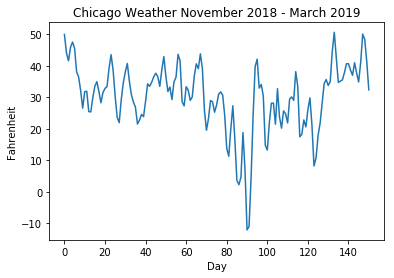

In [16]:
plt.plot(weather_df['TAVG'])
plt.title('Chicago Weather November 2018 - March 2019')
plt.xlabel('Day')
plt.ylabel('Fahrenheit')
#plt.savefig('tempbytime.png', transparent = True)
#feats['warm_weather'].mean()

Text(0, 0.5, 'Inches')

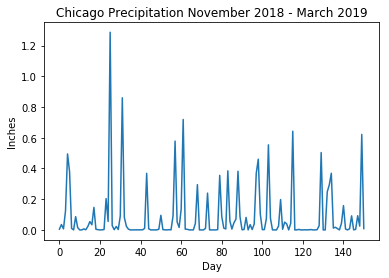

In [17]:
plt.plot(weather_df['PRCP'])
plt.title('Chicago Precipitation November 2018 - March 2019')
plt.xlabel('Day')
plt.ylabel('Inches')
#plt.savefig('prcpbytime.png', transparent = True)
#feats['warm_weather'].mean()

Text(0, 0.5, 'Inches')

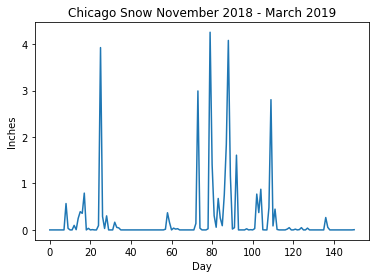

In [18]:
plt.plot(weather_df['SNOW'])
plt.title('Chicago Snow November 2018 - March 2019')
plt.xlabel('Day')
plt.ylabel('Inches')
#plt.savefig('snowbytime.png', transparent = True)
#feats['warm_weather'].mean()

The above graph is average tempurature for each day across the time period for which the data was available. (November 1, 2018 to March 29, 2019). Unfortunately, this data only covers the winter months in Chicago (the temperature never elevates above 50 F, so the effect of warmer weather on tipping behavior cannot be more fully explored).

## Data Exploration and Visualization

Questions Worth Answering:
- Are the amount of daily tips proportional to the number of rides per day? -- Daily Proportion of Tipped Rides Over Time. Tip Volume over Total Cost Volume
- Where do ride hailing pickups / dropoffs concentrate in?
- How does ride volume vary over time? Different time scales?
- How often and to what extent do patrons tip?
- How does average speed change with drop off location? Time of day?
- How likely is a rider to ride alone while still authorizing a pooled ride?
- What's the average cost of a rides being picked up and/or dropped off in Chicago?

- How much cheaper per mile is authorizing a shared ride?
- Calculate average tip for pick up / drop off location.
-------

Correlation matrix between all of the variables.
    Then visualize interesting correlations
Tipped vs. Share Authorized
speed_avg_mph vs. weather
Fare vs. Weather
Average Fare and Additional Costs amount per trip time.
Speed vs. Tips
Tipping vs. Community Area Ride Frequency.

--------

Narrative must ultimately highlight and motivate an understanding of ride tips.

The other questions can be framed as curiosities.

From the driver perspective, knowing where patrons are more likely to tip can improve payout.

From a developer perspective, understanding tipping behavior can help ensure that drivers are more fairly compensated within the payment model.

There are so many tipping possibilities, it's pointless to try to and explore other facets of the data

In [19]:
trips_df['tipped'].mean()

0.17140909865394446

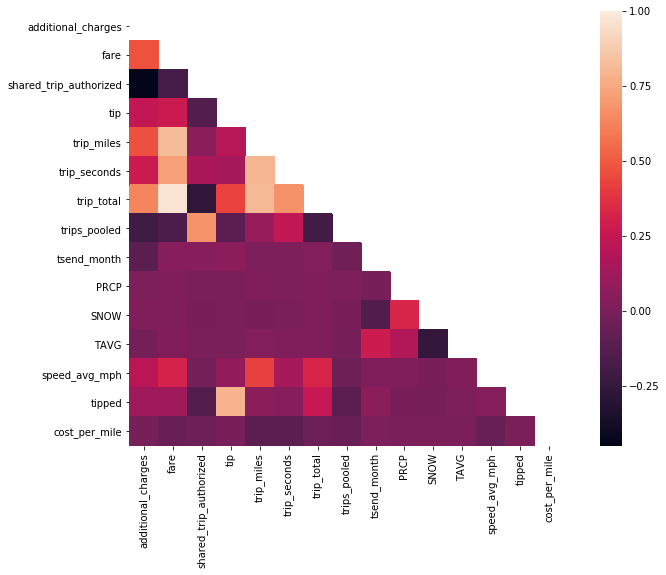

In [20]:
corr_cols = ['additional_charges', 'fare','shared_trip_authorized', 'tip',
             'trip_id', 'trip_miles', 'trip_seconds', 'trip_total', 'trips_pooled','tsend_month',
             'DATE','PRCP', 'SNOW', 'TAVG', 'speed_avg_mph', 'tipped', 'cost_per_mile']
corrmat = trips_df[corr_cols].corr()

mask = np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(13,8))
sns.heatmap(corrmat, mask=mask, square = True)

#plt.savefig('ridecorr.png', transparent=True)
plt.show()

Important Correlations:

- Tip amount and tipped status show no significant correlations with any of the features (besides total amount, which includes the tip amount). So immediately, we know that there isn't one single features that contributes definitively to the tip amount.

- Cost per mile, rightly so, has no correlation with any other features in the data set.

- None of the weather variables (Average Temperature in Fahrenheit, snow inches, and precipitation inches) correlates with the other features.

- In fact, it is surprising that weather doesn't to have any correlation on the average speed of each ride.

- Authorizing a shared trip primarily decreases the additional charges on a ride. Authorizing a shared ride also doesn't correlate strongly with a positive increase in trip time; however, trip time does positively correlate somewhat with the number rides pooled into one route.

- Speed of a ride also doesn't correlate with higher driver tips.

Overall, no overtly interesting correlations exist beyond the lack of correlation between potentially related ride variables.

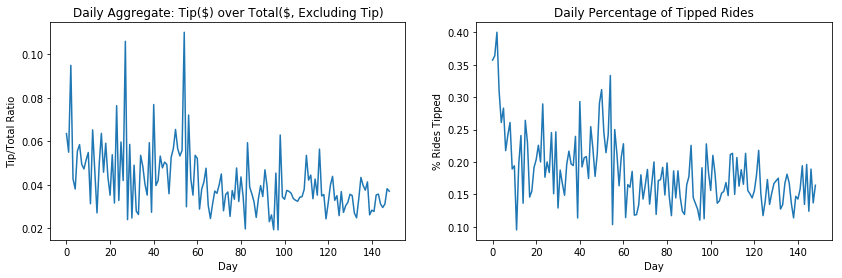

In [21]:
### Checking to see how tip rate and tipping volume changes daily

### Daily Tip Rate
tip_tot_ratios = (trips_df.groupby('DATE').sum()['tip'] / (trips_df.groupby('DATE').sum()['trip_total'] - trips_df.groupby('DATE').sum()['tip'])).reset_index().iloc[:,1]
tipped_ratios = trips_df.groupby('DATE').mean().reset_index()['tipped']

plt.figure(figsize=(14,4))

plt.subplot(1,2,1)
plt.plot(tip_tot_ratios)
plt.title('Daily Aggregate: Tip(\$) over Total(\$, Excluding Tip)')
plt.ylabel('Tip/Total Ratio')
plt.xlabel('Day')

plt.subplot(1,2,2)
plt.plot(tipped_ratios)
plt.title('Daily Percentage of Tipped Rides')
plt.ylabel('% Rides Tipped')
plt.xlabel('Day')

#plt.savefig('tipratios.png', transparent = True)

plt.show()


In [24]:
trips_df.columns

Index(['Unnamed: 0', 'additional_charges', 'dropoff_centroid_location',
       'dropoff_community_area', 'fare', 'pickup_centroid_location',
       'pickup_community_area', 'shared_trip_authorized', 'tip',
       'trip_end_timestamp', 'trip_id', 'trip_miles', 'trip_seconds',
       'trip_start_timestamp', 'trip_total', 'trips_pooled', 'tsend_year',
       'tsend_month', 'tsend_day', 'tsend_hour', 'tsend_minute', 'tsend_sec',
       'DATE', 'tsstart_year', 'tsstart_month', 'tsstart_day', 'tsstart_hour',
       'tsstart_minute', 'tsstart_sec', 'PRCP', 'SNOW', 'TAVG',
       'speed_avg_mph', 'tipped', 'warm_weather', 'cost_per_mile'],
      dtype='object')

### How often and to what extent do patrons tip?

In [22]:
text = 'For rides within Chicago, riders tip their drivers {}% of the time'
tip_freq = round(trips_df['tipped'].mean()*100,2)
print(text.format(tip_freq))

For rides within Chicago, riders tip their drivers 17.14% of the time


Text(0.5, 1.0, 'Boxplot Distribution of Tips (Excludes $0 Tips)')

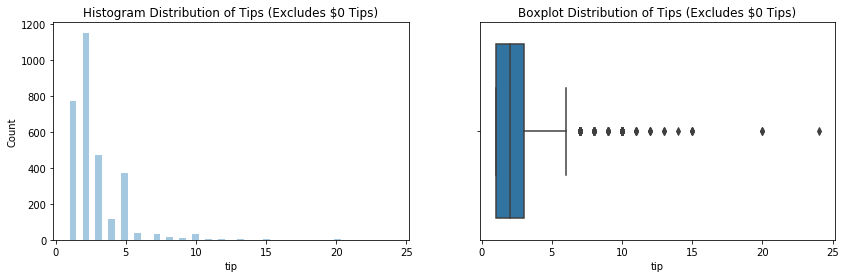

In [23]:
plt.figure(figsize = (14,4))

plt.subplot(1,2,1)
sns.distplot(trips_df[trips_df['tip'] > 0]['tip'], kde = False)
plt.title('Histogram Distribution of Tips (Excludes $0 Tips)')
plt.ylabel('Count')

plt.subplot(1,2,2)
sns.boxplot(x = trips_df[trips_df['tip'] > 0]['tip'])
plt.title('Boxplot Distribution of Tips (Excludes $0 Tips)')

#plt.savefig('tipdist.png', transparent = True)

The majority of are 5 dollars or less. There are a handful of outliers that exists for 7 dollar tips and above. The two graphs go hand in hand, since the boxplot makes it easier to visualize which tip values are actually present, while the histogram shows the density of the individual tip values, including the outlier tip values.

### Which pickup areas result in the best tipping frequency?

In [24]:
ca_tip_count = trips_df.groupby('pickup_community_area').sum()['tipped'].sort_values(ascending = False).head(10).reset_index()
ca_tip_freq = (trips_df.groupby('pickup_community_area').sum()['tipped'])/(trips_df.groupby('pickup_community_area').count()['tipped'])
ca_tip_freq = ca_tip_freq.sort_values(ascending=False).reset_index().head(10)

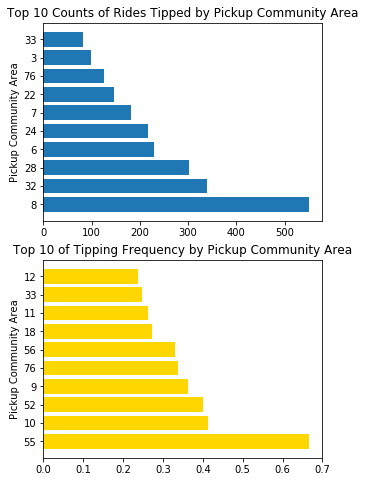

In [25]:
#params = {"ytick.color" : "w",
#          "xtick.color" : "w",
#          "axes.labelcolor" : "w",
#          "axes.edgecolor" : "w"}
#plt.rcParams.update(params)

plt.figure(figsize = (5,8))

plt.subplot(2,1,1)
plt.barh(ca_tip_count['pickup_community_area'].astype(int).astype(str), ca_tip_count['tipped'])
plt.title('Top 10 Counts of Rides Tipped by Pickup Community Area')
plt.ylabel('Pickup Community Area')

plt.subplot(2,1,2)
plt.barh(ca_tip_freq['pickup_community_area'].astype(int).astype(str), ca_tip_freq['tipped'], color ='gold')
plt.title('Top 10 of Tipping Frequency by Pickup Community Area')
plt.ylabel('Pickup Community Area')

#plt.savefig('pickuptips.png', transparent = True)

plt.show()

Although the top number of rides tipped in occur mostly in the datatown area (area 8, 32, 28, 24, and 6), another interesting metric was the rate of tipping based on the area that passengers were picked up from. Areas 55, 52, and 10 top the list of highest tipping rate, and these areas very far from teh downtown area. None of the downtowl location in the first graph measuring raw tipping counts made it the top list of tipping rates.

Below is the map of the Chicago Community areas pulled from Wikipedia. This is a standardized list of neighborhoods and areas mapped out to help social science research on the different communities and areas of Chicago.

![Map of Chicago Community Areas](https://upload.wikimedia.org/wikipedia/commons/2/24/Map_of_the_Community_Areas_and_%27Sides%27_of_the_City_of_Chicago.svg)

### Do dropoff community areas show interesting tipping behaviors?

Text(0, 0.5, 'Dropoff Community Area')

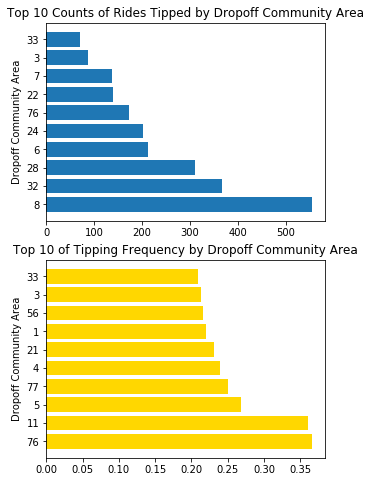

In [26]:
ca_tip_count = trips_df.groupby('dropoff_community_area').sum()['tipped'].sort_values(ascending = False).head(10).reset_index()
ca_tip_freq = (trips_df.groupby('dropoff_community_area').sum()['tipped'])/(trips_df.groupby('dropoff_community_area').count()['tipped'])
ca_tip_freq = ca_tip_freq.sort_values(ascending=False).reset_index().head(10)

plt.figure(figsize = (5,8))

plt.subplot(2,1,1)
plt.barh(ca_tip_count['dropoff_community_area'].astype(int).astype(str), ca_tip_count['tipped'])
plt.title('Top 10 Counts of Rides Tipped by Dropoff Community Area')
plt.ylabel('Dropoff Community Area')

plt.subplot(2,1,2)
plt.barh(ca_tip_freq['dropoff_community_area'].astype(int).astype(str), ca_tip_freq['tipped'], color ='gold')
plt.title('Top 10 of Tipping Frequency by Dropoff Community Area')
plt.ylabel('Dropoff Community Area')

#plt.savefig('dropofftips.png', transparent = True)


Again, many of the downtown locations result in the highest number of tipped rides, but the community areas with the higher rates include areas 76, 11, and 5, none of which are downtown. Area 76 corresponds to the Chicago Ohare International airport - so it's clear that people getting dropped off to the airport love to tip their drivers.

### Does distance affect tipping rate at all? And which pickup areas correspond to the greatest average trip distances?

In [69]:
corr = np.corrcoef(trips_df['trip_miles'],trips_df['tip'])[0,1]
text = 'While the correlation between distance and'

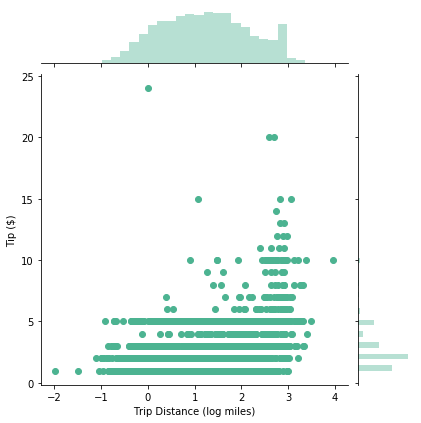

In [27]:
X = np.log(trips_df[(trips_df['tip'] > 0) & (trips_df['trip_miles'] > 0)]['trip_miles'])
Y = trips_df[(trips_df['tip'] > 0) & (trips_df['trip_miles'] > 0)]['tip']

ax = sns.jointplot(x = X, y = Y, color = "#4CB391")
ax.set_axis_labels('Trip Distance (log miles)','Tip ($)')

#plt.savefig('tipdistscat.png', transparent = True)

plt.show()

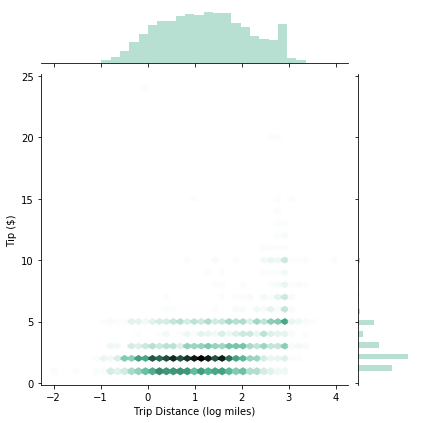

In [28]:
ax = sns.jointplot(x = X, y = Y, color = "#4CB391", kind = 'hex')
ax.set_axis_labels('Trip Distance (log miles)','Tip ($)')

# plt.savefig('tipdistdense.png', transparent = True)

plt.show()

With the logged distanced plotted against tips that drivers receiver for their rides, it's clear that longer drives result it higher tips, but a higher tip isn't guaranteed - the triangular shape of the dat is shows this. 0 dollar - 5 dollar tips run the range of trip distances, while simply driving for longer trips result in a higher probability of getting a larger tip.

Text(0, 0.5, 'Pickup Community Area')

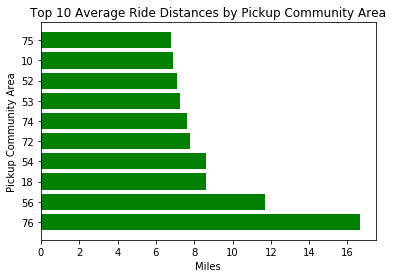

In [29]:
pickup_dists = trips_df.groupby('pickup_community_area').mean()['trip_miles'].sort_values(ascending = False).head(10).reset_index()
plt.barh(pickup_dists['pickup_community_area'].astype(int).astype(str), pickup_dists['trip_miles'], color = 'g')
plt.title('Top 10 Average Ride Distances by Pickup Community Area')
plt.xlabel('Miles')
plt.ylabel('Pickup Community Area')

The pick community areas that result in the longest trip distances are area 56 and area 76, which are the Midway and  O'hare Internationl airports respectively. 

## Preprocessing the Data for Modeling

In [30]:
from scipy.stats import mstats

In [31]:
trips_df.columns

Index(['Unnamed: 0', 'additional_charges', 'dropoff_centroid_location',
       'dropoff_community_area', 'fare', 'pickup_centroid_location',
       'pickup_community_area', 'shared_trip_authorized', 'tip',
       'trip_end_timestamp', 'trip_id', 'trip_miles', 'trip_seconds',
       'trip_start_timestamp', 'trip_total', 'trips_pooled', 'tsend_year',
       'tsend_month', 'tsend_day', 'tsend_hour', 'tsend_minute', 'tsend_sec',
       'DATE', 'tsstart_year', 'tsstart_month', 'tsstart_day', 'tsstart_hour',
       'tsstart_minute', 'tsstart_sec', 'PRCP', 'SNOW', 'TAVG',
       'speed_avg_mph', 'tipped', 'warm_weather', 'cost_per_mile'],
      dtype='object')

In [32]:
trips_ppdf = trips_df[['additional_charges',
       'dropoff_community_area', 'fare',
       'pickup_community_area', 'shared_trip_authorized', 'tip',
       'trip_miles', 'trip_seconds',
       'trip_total', 'trips_pooled','tsstart_month', 'PRCP', 'SNOW', 'TAVG',
       'speed_avg_mph', 'tipped', 'cost_per_mile']]

#replacing infinite values for NaN's, this will allow you to observe the skew values of each feature distribution.
trips_ppdf = trips_ppdf.replace([np.inf,-np.inf],np.nan)

#Winsorizing the Speed feature to remove outliers
speed_winzd = mstats.winsorize(trips_df['speed_avg_mph'], limits=[0, 0.00012])
trips_ppdf['speed_avg_mph'] = speed_winzd

#Winsorizing the cost_per_mile 
costpmi_winzd = mstats.winsorize(trips_ppdf['cost_per_mile'], limits=[0,0.001])
trips_ppdf['cost_per_mile'] = costpmi_winzd

display(trips_ppdf.info())
trips_ppdf.isnull().sum().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17607 entries, 0 to 19999
Data columns (total 17 columns):
additional_charges        17607 non-null float64
dropoff_community_area    17607 non-null float64
fare                      17607 non-null float64
pickup_community_area     17607 non-null float64
shared_trip_authorized    17607 non-null bool
tip                       17607 non-null int64
trip_miles                17607 non-null float64
trip_seconds              17607 non-null float64
trip_total                17607 non-null float64
trips_pooled              17607 non-null int64
tsstart_month             17607 non-null int64
PRCP                      17607 non-null float64
SNOW                      17607 non-null float64
TAVG                      17607 non-null float64
speed_avg_mph             17607 non-null float64
tipped                    17607 non-null int64
cost_per_mile             17607 non-null float64
dtypes: bool(1), float64(12), int64(4)
memory usage: 2.3 MB


None

0

In [33]:
trips_ppdf.skew()

additional_charges        1.709881
dropoff_community_area    1.095558
fare                      2.745084
pickup_community_area     1.108117
shared_trip_authorized    0.961308
tip                       4.420335
trip_miles                2.043672
trip_seconds              2.517754
trip_total                2.766949
trips_pooled              3.158897
tsstart_month             1.476500
PRCP                      2.883512
SNOW                      4.024269
TAVG                     -0.808179
speed_avg_mph             1.485458
tipped                    1.743956
cost_per_mile             2.568639
dtype: float64

In [34]:
(trips_ppdf == np.inf).sum()

additional_charges        0
dropoff_community_area    0
fare                      0
pickup_community_area     0
shared_trip_authorized    0
tip                       0
trip_miles                0
trip_seconds              0
trip_total                0
trips_pooled              0
tsstart_month             0
PRCP                      0
SNOW                      0
TAVG                      0
speed_avg_mph             0
tipped                    0
cost_per_mile             0
dtype: int64

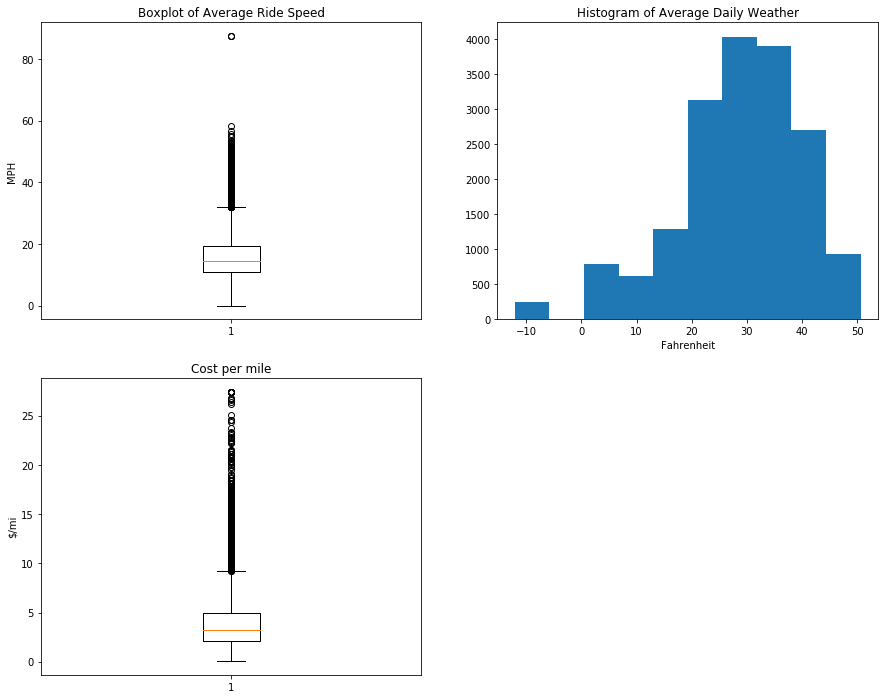

In [35]:
plt.figure(figsize=(15,12))

plt.subplot(2,2,1)
plt.boxplot(trips_ppdf['speed_avg_mph'])
plt.title('Boxplot of Average Ride Speed')
plt.ylabel('MPH')

plt.subplot(2,2,2)
plt.title('Histogram of Average Daily Weather')
plt.xlabel('Fahrenheit')
plt.hist(trips_ppdf['TAVG'])

plt.subplot(2,2,3)
plt.boxplot(trips_ppdf['cost_per_mile'])
plt.title('Cost per mile')
plt.ylabel('$/mi')

plt.show()

Although the above distributions show skew, this was after they were winsorized for incredibly large outliers. The amount of skew presented in the above graphs is a great improvement, and acceptable for analysis.

In [36]:
trips_ppdf = trips_df[['additional_charges',
       'dropoff_community_area', 'fare',
       'pickup_community_area', 'shared_trip_authorized', 'tip',
       'trip_miles', 'trip_seconds',
       'trip_total', 'trips_pooled','tsstart_month', 'PRCP', 'SNOW', 'TAVG',
       'speed_avg_mph', 'tipped', 'cost_per_mile']]

#replacing infinite values for NaN's
trips_ppdf = trips_ppdf.replace([np.inf,-np.inf],np.nan)

#Winsorizing the Speed feature to remove outliers
speed_winzd = mstats.winsorize(trips_df['speed_avg_mph'], limits=[0, 0.00012])
trips_ppdf['speed_avg_mph'] = speed_winzd

#Dropping rows with infinite values in the cost_per_mile feature
#trips_ppdf = trips_ppdf[~trips_ppdf.isin([np.nan, np.inf, -np.inf]).any(1)]

#Winsorizing the cost_per_mile 
costpmi_winzd = mstats.winsorize(trips_ppdf['cost_per_mile'], limits=[0,0.001])
trips_ppdf['cost_per_mile'] = costpmi_winzd

#Changing int columns to categorical variables.
cols_to_str = ['pickup_community_area', 'dropoff_community_area']
for col in cols_to_str:
    trips_ppdf[col] = trips_ppdf[col].astype(int).astype(str)

#log transforming right skewed data to normalize distributions
cols_to_log = ['additional_charges', 'tip', 'trip_miles', 'trip_seconds', 'trip_total',
               'trips_pooled', 'PRCP', 'SNOW', 'speed_avg_mph', 'cost_per_mile']
for col in cols_to_log:
    trips_ppdf[col] = np.log(trips_ppdf[col] + 0.01) # Adding 0.01 to all trips to prevent infinite values

# Cube root transforming fare
trips_ppdf['fare'] = trips_ppdf['fare']**(1/3)

# Binarizing the community areas
trips_ppdf = pd.get_dummies(trips_ppdf, columns = ['pickup_community_area','dropoff_community_area'],
                           prefix = ['pickup', 'dropoff'])

#Dropping rows with NaN values.
#trips_ppdf = trips_ppdf.dropna(axis=0)

#Checking for any inf or nan values
indeterminates = trips_ppdf.isin([np.nan,np.inf,-np.inf]).sum().sum()
print('The dataset is preprocessed and ready for modeling. There are {} indeterminate values in the dataset.'.format(indeterminates))

The dataset is preprocessed and ready for modeling. There are 0 indeterminate values in the dataset.


In [34]:
#Winsorize by
##df['col'] = df['col'].apply(lambda x: cut_num2 if x > cut_num2 else x)

In [37]:
display(trips_ppdf[cols_to_log].skew())
trips_ppdf['fare'].skew()

additional_charges   -2.067862
tip                   1.802414
trip_miles           -0.042950
trip_seconds         -0.231731
trip_total            0.061116
trips_pooled          1.929303
PRCP                  0.921970
SNOW                  1.348444
speed_avg_mph        -0.501136
cost_per_mile        -0.150557
dtype: float64

-0.08734611496299875

## Dimensionality Reduction

In [38]:
from sklearn.decomposition import PCA

In [39]:
trips_ppdf.shape

(17607, 169)

In [40]:
#Splitting features into independent and target variables
Y1 = trips_ppdf['tipped'] #Classification Model
Y2 = trips_ppdf['tip'] #Regression Model
X = trips_ppdf.loc[:, ~(trips_ppdf.columns).isin(['tipped','tip'])]

#Performing PCA Dimension Reduction
pca = PCA(n_components = 15)
PCs = pca.fit_transform(X)

#Variance Captured by Principal Components
pca_evr = pca.explained_variance_ratio_
print(pca_evr)
pca_evr.sum()

[8.42850057e-01 8.16729149e-02 2.25620333e-02 1.96576033e-02
 1.13246095e-02 5.66134300e-03 2.68873555e-03 1.38796988e-03
 9.64412729e-04 8.67112427e-04 6.51486690e-04 6.17926003e-04
 5.90269211e-04 5.65680209e-04 4.88431015e-04]


0.9925505846111778

## Modeling the data to predict Tipping Behavior

For the following model iterations, regression models were not used because the data concentrated heavliy in $0 Tip values, making classification models better suited to model the data.

In [41]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [42]:
#Classifier function that trains and tests on the same data

#X = PCs
#Y = trips_ppdf['tipped']
#clf = GradientBoostingClassifier()

def TipCLF(clf, Xtrain, Ytrain, cv = 10):
    clf.fit(Xtrain,Ytrain)
    print('Cross Validation Scores:')
    print(cross_val_score(clf, Xtrain, Ytrain, cv=cv))
    
    preds = clf.predict(Xtrain)
    pred_counts = (preds == Ytrain).value_counts()
    print('\nOverall Accuracy: {}'.format(pred_counts[1]/pred_counts.sum()))
    print('{} total misclassified out of {}.'.format(pred_counts[0],pred_counts.sum()))
    conmax = confusion_matrix(Ytrain,preds)
    print('\nType 2 Error / Tipped Rides predicted as Untipped: {}'.format(conmax[1,0]/conmax[1].sum()))
    print('\nType 1 Error / Untipped Rides predicted as Tipped: {}'.format(conmax[0,1]/conmax[0].sum()))

In [43]:
#Classifier function that trains and tests on different data sets

#X = PCs
#Y = trips_ppdf['tipped']
#clf = GradientBoostingClassifier()

def TipCLF_Split(clf, Xtrain, Ytrain, Xtest, Ytest, cv = 10):
    clf.fit(Xtrain,Ytrain)
    print('\nCross Validation Scores:')
    print(cross_val_score(clf, Xtrain, Ytrain, cv=cv))
    
    preds = clf.predict(Xtest)
    pred_counts = pd.Series(preds == Ytest).value_counts() ##pd.Series() added for .value_counts() method to function
    print('\nOverall Accuracy of trained model on Test Data: {}'.format(pred_counts[1]/pred_counts.sum()))
    print('{} total misclassified out of {}.'.format(pred_counts[0],pred_counts.sum()))
    conmax = confusion_matrix(Ytest,preds)
    print('\nType 2 Error / Tipped Rides predicted as Untipped: {}'.format(conmax[1,0]/conmax[1].sum()))
    print('Type 1 Error / Untipped Rides predicted as Tipped: {}'.format(conmax[0,1]/conmax[0].sum()))
    print('\nPrecision / True Positives over All Predicted as Tipped: {}'.format(conmax[1,1]/conmax[:,1].sum()))
    print('Recall / True Tipped Predicitions over All Actual Tips : {}'.format(conmax[1,1]/conmax[1].sum()))

### Iteration 1: Random Forest Classifier

In [105]:
from sklearn.ensemble import RandomForestClassifier

X = PCs
Y = trips_ppdf['tipped']
clf = RandomForestClassifier(n_estimators = 50)

TipCLF(clf,X,Y)

Cross Validation Scores:
[0.83021011 0.82453152 0.82907439 0.82737081 0.82737081 0.8109029
 0.82623509 0.82112436 0.77954545 0.82717453]

Overall Accuracy: 0.9996592264440279
6 total misclassified out of 17607.

Type 2 Error / Tipped Rides predicted as Untipped: 0.0019880715705765406

Type 1 Error / Untipped Rides predicted as Tipped: 0.0


In [107]:
(trips_ppdf['tipped'] == 1).sum()/len(trips_ppdf['tipped'])

0.17140909865394446

The CV scores seems indicate that the model is not randomly guessing (overall tip rate is 17.14% corresponding to an 82.86% random guess accuracy rate); the overall accuracy of the model when trained and tested on the same data shows an accuracy of nearly 100%. This is probably due to fact that the random forest model 'memorizes' what the outcome of the this data is rather than predicting the outcome the train data. This is why it's important to test on the model on training data, which will be performed in the next model iteration.

### Iteration 2: Random Forest Classifier, with resample and test/train split data
This is iteration will improve upon the previous by rebalancing the sample data, then running this retrained Random Forest Classifier model on new data.

In [108]:
print('Tipped: ', trips_ppdf[trips_ppdf['tipped'] == 1].shape[0])
print('Untipped: ', trips_ppdf[trips_ppdf['tipped'] == 0].shape[0])

### Older resampling method
#trips_tipped = resample(trips_ppdf[trips_ppdf['tipped'] == 1], replace = True, n_samples = 5000)
#trips_untipped = resample(trips_ppdf[trips_ppdf['tipped'] == 0], replace = True, n_samples = 5000)
#trips_bal_ppdf = pd.concat([trips_tipped, trip_untipped])

Tipped:  3018
Untipped:  14589


In [133]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

#Resampling data using SMOTE to create a balance training set.
resample_size = len(trips_ppdf[trips_ppdf['tipped']==0])

print('Original dataset shape %s' % Counter(Y1))
sm = SMOTE(sampling_strategy = {0:resample_size, 1:resample_size})
X_res, Y1_res = sm.fit_resample(PCs, Y1)
print('Resampled dataset shape %s' % Counter(Y1_res))

X_train, X_test, Y_train, Y_test = train_test_split(X_res, Y1_res , test_size=0.40, random_state=4)

#Fitting and testing the model
clf = RandomForestClassifier(n_estimators = 50)
TipCLF_Split(clf, X_train, Y_train, X_test, Y_test)

Original dataset shape Counter({0: 14589, 1: 3018})
Resampled dataset shape Counter({0: 14589, 1: 14589})

Cross Validation Scores:
[0.84646119 0.86750428 0.83780697 0.85608224 0.85494003 0.84914286
 0.868      0.85542857 0.84       0.84      ]

Overall Accuracy of trained model on Test Data: 0.8554660726525017
1687 total misclassified out of 11672.

Type 2 Error / Tipped Rides predicted as Untipped: 0.14116002795248078

Type 1 Error / Untipped Rides predicted as Tipped: 0.14778076664425016


These results are definitely more realistic. The overall accuracy and the CV scores match, indicating that the model is behaving consistently for different sets of data. Also, because training and test sets were balanced using SMOTE, an overall accuracy score of 85.39% is quite good considering that randomly guessing would result in a 50% accuracy.

### Iteration 3: Support Vector Classifier
Using the same train/test split data as the previous iteration, this iteration aims to improve the predictive accuracy of the model.

In [110]:
from sklearn.svm import SVC

X_train, X_test, Y_train, Y_test = train_test_split(X_res, Y1_res , test_size=0.40, random_state=4)

clf = SVC()
TipCLF_Split(clf, X_train, Y_train, X_test, Y_test)


Cross Validation Scores:
[0.68892694 0.70474015 0.69503141 0.6933181  0.68418047 0.69028571
 0.71085714 0.68914286 0.688      0.68628571]

Overall Accuracy of trained model on Test Data: 0.69645305003427
3543 total misclassified out of 11672.

Type 2 Error / Tipped Rides predicted as Untipped: 0.2321802935010482

Type 1 Error / Untipped Rides predicted as Tipped: 0.3722259583053127


### Iteration 4: Gradient Boosting Classifier

In [143]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, Y_train, Y_test = train_test_split(X_res, Y1_res , test_size=0.40, random_state=4)

clf = GradientBoostingClassifier(max_depth = 11, n_estimators = 165, learning_rate = 0.25)
TipCLF_Split(clf, X_train, Y_train, X_test, Y_test)


Cross Validation Scores:
[0.87442922 0.89605939 0.87549971 0.88406625 0.88235294 0.86857143
 0.88571429 0.86685714 0.86       0.87885714]

Overall Accuracy of trained model on Test Data: 0.8803118574366005
1397 total misclassified out of 11672.

Type 2 Error / Tipped Rides predicted as Untipped: 0.11809923130677848
Type 1 Error / Untipped Rides predicted as Tipped: 0.12121721587088097

Precision / True Positives over All Predicted as Tipped: 0.875021667533368
Recall / True Tipped Predicitions over All Actual Tips : 0.8819007686932215


In [ ]:
# Precision and Recall
# Precision = TP/(TP + FP)
# Recall = TP/(TP + FN)



### Optimizing Gradient Boosting Classifier using Hyperopt

Using Hyperopt, we take a smaller sample of the SMOTE resampled dataset to iterate over a designated hyperparameter space within the another Gradient Boosting Classifier model. In doing so, we will use the parameters in hyperopt that return the highest accuracy as parameter inputs for the original GBC classifier above. The smaller sample allows the hyperopt parameter optimizer to iterate more quickly through different parameter permutations, and in this case we used a data set 3 times smaller than the training set for the original classifier.

The results, as seen below, are as follows:
- Learning Rate: 0.25
- Max Depth: 11
- N Estimators: 145

Plugging these values into the model above, GradientBoostingClassifier returns an accuracy of 88.03% which is a slight improvement from non-optimized GBC which bounced between 86% and 87% when modeled randomly.

In [130]:
from sklearn.utils import resample
import math

#Splitting features into independent and target variables
Y1 = trips_ppdf['tipped'] #Classification Model
Y2 = trips_ppdf['tip'] #Regression Model
X = trips_ppdf.loc[:, ~(trips_ppdf.columns).isin(['tipped','tip'])]

#Performing PCA Dimension Reduction
pca = PCA(n_components = 15)
PCs = pca.fit_transform(X)

#Resampling data using SMOTE to create a balance training set.
resample_size = len(trips_ppdf[trips_ppdf['tipped']==0])  
sm = SMOTE(sampling_strategy = {0:resample_size, 1:resample_size})
X_res, Y1_res = sm.fit_resample(PCs, Y1)

# Reduce Dataset By a Factor of 3 for faster Hyperopt Iterations
sample_redux_size = math.ceil(resample_size/3)

# Resampling; Keep randomstates the same to ensure the feature data and target data are ordered similarly.
X_res_hp = resample(X_res, replace = False, n_samples = sample_redux_size, random_state = 15)
Y1_res_hp = resample(Y1_res, replace = False, n_samples = sample_redux_size, random_state = 15)

print('Original dataset shape %s' % Counter(Y1))
print('Resampled dataset shape %s' % Counter(Y1_res_hp))

Original dataset shape Counter({0: 14589, 1: 3018})
Resampled dataset shape Counter({1: 2460, 0: 2403})


In [131]:
print(Y1_res_hp.shape)
X_res_hp.shape

(4863,)


(4863, 15)

In [132]:
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK

X_train, X_test, Y_train, Y_test = train_test_split(X_res_hp, Y1_res_hp , test_size=0.40, random_state=4)

def hyperopt_train_test(params):
    clf = GradientBoostingClassifier(**params)
    clf.fit(X_train, Y_train)
    preds = clf.predict(X_test)
    pred_counts = pd.Series(preds == Y_test).value_counts()
    return pred_counts[1]/pred_counts.sum()
    #return cross_val_score(clf, X, y).mean()

space4rf = {
    'max_depth': hp.choice('max_depth', range(5,20)),
     #'max_features': hp.choice('max_features', range(1,5)),
    'learning_rate': hp.choice('learning_rate', [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 1]),
    'n_estimators': hp.choice('n_estimators', range(50,150)),
    #'criterion': hp.choice('criterion', ["friedman_mse", "mse", "mae"]),
}

best = 0

def f(params):
    global best
    acc = hyperopt_train_test(params)
    if acc > best:
        best = acc
        print('new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()

best = fmin(f, space4rf, algo=tpe.suggest, max_evals = 50, trials=trials)
print('best:')
print(best)

new best:                                           
0.7291880781089414                                  
{'learning_rate': 1, 'max_depth': 16, 'n_estimators': 125}
new best:                                                                     
0.7579650565262076                                                            
{'learning_rate': 0.1, 'max_depth': 11, 'n_estimators': 117}                  
new best:                                                                      
0.7595066803699897                                                             
{'learning_rate': 0.25, 'max_depth': 11, 'n_estimators': 55}                   
new best:                                                                      
0.7656731757451182                                                             
{'learning_rate': 0.25, 'max_depth': 11, 'n_estimators': 145}                  
new best:                                                                      
0.7672147995889003                    

Conclusion:

After four model iterations, the gradient boosting classifier resulted in the highest accuracy rate to predict whether a ride would result a driver tip at 88.03% overall accuracy, and Type 2 error of 12.3% and Type 1 error of 14.15%. Precision is at 87.5%, which means that of all the predicted Tipped rides, 87.5% were actually tipped. Recall is at 88.2% which the percetage of all actual tipped rides that were classified as tips. These high scores were all achieved without using data about the driver's performance and customer service aptitude, but simply using timing, location, and weather.

The training data was resampled using SMOTE to create a 50/50 split between tipped and untipped rides, and this new resampled data set was used to fit the models. The GBC model resulted in 88.03% accuracy rate which corresponds closely to the 17.14% tipping rate of original data classes. Thus, it is not clear whether the accuracy is significantly different from random guessing, but I think that's why we have the precesion and recall measures to further evaluate the model.

Hyperopt was employed to optimize the parameters of the GBC model, and the overall accuracy improved the gradient boosting classifier by 1% to achieve an 88% accuracy score.

---------

Overall, this model is imporant in predicting tips based solely on the logistics of the ride that the driver (weather, dropoff, locations) and is a great compliment when predicting tips, if as employee of ride hailing service, I can then complement more rigorous data on driver and passenger behavior into tipping predictions.

Also, understanding how drivers are being compensated can help to improve who drivers are being compensated, both on the driver side and the business side.

Learning to predict tips can also help drivers more strategically plan their rides if they consider the geographic and temporal factors of tipping behavior.